In [1]:
from google.cloud import vision
from google.cloud import storage
from PIL import Image
import numpy as np
import os, sys
from helper import *
import csv  
from io import BytesIO
from IPython import display

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r"../guppies-test-4c48569421d8.json"

### Read all files from the google bucket. Can cycle through the files in this list and write results to the csv file.

In [2]:
# Read all JPG files. All images are in both .jpg and .nef formats, need to avoid duplicates.
all_files = ListAvaliableFiles("guppy_images")
all_jpg_files = [ x for x in all_files if "JPG" in x ]

# Read the random number array we will use to assign images.
# random_array = np.arange(len(all_jpg_files))
# np.random.shuffle(random_array)
# np.save('../Data/radom_array.npy', random_array)
random_array = np.load('../Data/radom_array.npy')

# Assign images.
Jordan_array = random_array[0:500]
Sunny_array = random_array[500:1000]

Jordan_files = []
Sunny_files = []

for index in Jordan_array:
    Jordan_files.append(all_jpg_files[index])

for index in Sunny_array:
    Sunny_files.append(all_jpg_files[index])

### Opens a file from the google bucket (or locally, depends if using RetreiveImage (cloud) or LoadImage (local)), crops it, reads it and corrects the output.

In [3]:
"""Retreive cloud image"""
# file = all_jpg_files[50]
file= '1301/Lower Lalaja/28A/100NCD60/DSC_1728.JPG'
image = RetreiveImage(file, verbose=True)

"""Read local image"""
# file = '/Users/jordan/Desktop/Guppies/Data/raw/DSC_1053.JPG'
# image = LoadImage(file)

cropped_image = CroppedImage(image, verbose=True)
output_string, word_confidences = ReadImage(cropped_image, verbose=True)
label = FindErrors(output_string, verbose=True)
print("Initial label:", output_string,
      "\nCorrected label:", label)


Image has been read from google bucket.

Image has been cropped.

Output: MLL-150-01/28/13 
Confidence: 0.7101017336057419

Removing special characters from the output string (e.g. '.', '|').
characters ( have been replaced with 1
characters \ have been replaced with 1
characters ( have been replaced with 1
characters \ have been replaced with 1
characters ( have been replaced with 1
characters \ have been replaced with 1
Character M is fine.
Character L is fine.
Character L is fine.
Character - is fine.
Character 1 is fine.
Character 5 is fine.
Character 0 is fine.
Character - is fine.
Character 0 is fine.
Character 1 is fine.
Character / is fine.
Character 2 is fine.
Character 8 is fine.
Character / is fine.
Character 1 is fine.
Character 3 is fine.
String after preprocessing: ['MLL', '150', '01/28/13']

Correct number of paragraphs.

Looking for errors in the title (MLL).
Final title: MLL

Looking for errors in the identity (150).
Incorrect identity length. Identity has 3 elements,

In [ ]:
Image.open(image)

### Write filename, initial prediction, corrected prediction and the manually inputted truth to the truth.csv file for a set of file names.
The files have been randomised and split.

In [ ]:
with open('../Data/truth.csv', 'a') as f:
    writer = csv.writer(f)

    for file in Sunny_files:
        # Read the data and predict the label.
        image = RetreiveImage(file, verbose=False)
        cropped_image = CroppedImage(image, verbose=False)

        display.display(Image.open(cropped_image))
        display.clear_output(wait=True)

        initial_prediction = ReadImage(cropped_image, verbose=False)[0]
        corrected_prediction = FindErrors(initial_prediction)
    
        # Provide truth
        truth = input("Truth:")

        writer.writerow([file, initial_prediction, corrected_prediction, truth])

### Read through all cloud files and write filename, initial prediction and corrected prediction to the predictions.csv file.

In [ ]:
files = all_jpg_files
with open('../Data/predictions.csv', 'w') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(['filename', 'prediction', 'corrected'])

    for i, file in enumerate(files):    
        print(f'{i+1}/{len(files)}',end='\r')

        # Read the data
        image = RetreiveImage(file, verbose=False)
        cropped_image = CroppedImage(image, verbose=False)
        Image.open(cropped_image)
        initial_prediction = ReadImage(cropped_image, verbose=False)[0]
        corrected_prediction = FindErrors(initial_prediction)
        
        # write the data
        writer.writerow([all_files[i], initial_prediction, corrected_prediction])

### Some code to reanalyse predictions once we have changed the algorithm

In [4]:
import csv

pred_file = 'Truth'

with open(f'../Data/{pred_file}_new.csv', 'w') as f_new:
    with open(f'../Data/{pred_file}.csv', 'r') as f:
        filereader = csv.reader(f)
        writer = csv.writer(f_new)
        for n, row in enumerate(filereader):
            if row != []:
                new_row = row[:2]

                new_prediction = FindErrors(row[1])

                new_row.append(new_prediction)
                new_row.append(row[3])

                writer.writerow(new_row)


now delete old file and rename new one.

### Some code to check the accuracy of the algorithm

In [16]:
import csv

correct_files = []
incorrect_files = []
invalid_files = []

character_confusions = []


with open(f'../Data/{pred_file}_new.csv', 'r') as f:
    filereader = csv.reader(f)
    for n, row in enumerate(filereader):
        if row != []:
            correct = int(row[3] == row[2])
            if correct:
                correct_files.append(row[0])

            if not correct:
                if row[2] == '1':
                    invalid_files.append(row[0])
                    print(n + 1, "Invalid")

                else: 
                    true = row[3].split('-')
                    pred = row[2].split('-')

                    incorrect_files.append(row[0])

                    if len(true) != 3 or len(pred) != 3:
                        print(n, 'error')
                        continue

                    for i in range(3):
                        if true[i] != pred[i]:
                            print(n + 1, true[i], pred[i])

                            if (i == 1) and (len(true[i]) == len(pred[i])): #mistake in identity.
                                for j in range(len(true[i])):
                                    if true[i][j] != pred[i][j]:
                                        character_confusions.append((true[i][j], pred[i][j]))




print("\nNumber Correct:", len(correct_files), 
      "\nNumber Incorrect:", len(incorrect_files),
      "\nNumber Invalid:", len(invalid_files))

character_confusions =np.array(character_confusions)

3 3F4F 3S4S
11 3P6W 3PLAW
13 3Y6G 3Y6G5
27 1O4K 1O4I
31 4O7Y 9O7Y
37 Invalid
41 2G5G 2G5G2
47 1K7K 1I7K
59 Invalid
65 Invalid
67 2W7V QW7V
73 1N8F 1N5F
87 1O5P 1O5G
99 2B8W 2B3W
101 7W8G 7I8G
115 4W5W 4W5WN
125 4N5O 4I5O
127 5P7K 4SPYK
131 2K8B 2K8B2I8
147 Invalid
153 4O7B 4O7F
171 5S7B 5B7P
191 6Y7P 6Y2P
193 6V7P 6V2P
195 1Y8R 1Y8P
197 Invalid
199 5K6O 5Y6O
201 2R6Y 2ROY
203 1F5F JF5G
207 1V2G7G 1S6Y6
209 5P7V 5F7V
219 3R7V 3R2V
221 3W7V NFMF
227 1F3O 1G3O
231 2B5G 2R5G
235 5R6W 5R8W
237 2R5R 2R1R
249 Invalid
279 1R8G 1R5C
283 2N4F 2N7F
299 7V8G 7O8G
307 4V8G 4I8G
311 Invalid
317 1G6S 1Y6S
319 2F8O 2G8O
331 1K7Y 1I2Y4
333 Invalid
339 4V6O 4I6O
367 3O4R 3O4F
371 Invalid
373 1R8Y 1R3Y
375 Invalid
387 3K4G8K 3K4Y8K
389 1Y4K LY4K
401 4K8K 4K5K
409 1Y4N JY4N
413 2W4S 2W7W
417 3B7R 3F7R
419 1O2O7P 1O2O7O
423 2O3O7W 0B0YW
425 3R8Y 3S8I
429 4V8K 4I8I
441 1/28/13 01/28/13
443 1V8Y 1V3Y
447 Invalid
453 1B4K 1F4K
457 1K4W WK4W
458 error
461 4P5O 495O
463 FFTY FTY
473 1K2K7R 0IKSKZR
489 Invalid
4

In [17]:
print("Attempted % Correct:", len(correct_files) / (len(correct_files) + len(incorrect_files)))
print("Total % Correct:", len(correct_files) / (len(correct_files) + len(incorrect_files) + len(invalid_files)))

Attempted % Correct: 0.7494736842105263
Total % Correct: 0.712


In [8]:
np.save('incorrect_files.npy',np.array(incorrect_files))

make the confusion matrix

In [18]:
chars = np.unique(character_confusions)

In [20]:
confusion_matrix =  np.zeros((len(chars), len(chars)))

for i in range(len(chars)):
    for j in range(len(chars)):
        confusion_matrix[i,j] = np.sum((character_confusions[:,0] == chars[i]) & (character_confusions[:,1] == chars[j]))

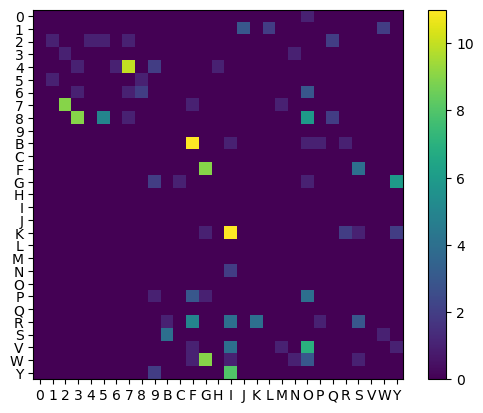

In [26]:
import matplotlib.pyplot as plt
plt.imshow(confusion_matrix)
plt.xticks(np.arange(len(chars)), chars)
plt.yticks(np.arange(len(chars)), chars)
plt.colorbar()

### Code returns the file name of all images we are currently not predicting accurately.

In [ ]:
def ErrorFiles(TruthPath):
    Error_Files = []
    Correct_Files = []
    Error_Indices = []
    Correct_Indices = []

    with open(TruthPath, 'r') as f:
        filereader = csv.reader(f)
        for n, row in enumerate(filereader):

            if row[2] == row[3]:
                file = row[0]
                Correct_Files.append(file)
                Correct_Indices.append(n)

            if row[2] != row[3]:
                file = row[0]
                Error_Files.append(file)
                Error_Indices.append(n)

    return Error_Files, Error_Indices, Correct_Files, Correct_Indices, 

### Reads image from error file array in full verbose mode.

In [ ]:
error_files, error_indices = ErrorFiles('../Data/Truth_new.csv')[:2]
index = 100
file = error_files[index]
file_index = error_indices[index]
image = RetreiveImage(file, verbose=True)

cropped_image = CroppedImage(image, verbose=True)
output_string, word_confidences = ReadImage(cropped_image, verbose=True)
label = FindErrors(output_string, verbose=True)
print("Initial label:", output_string,
      "\nCorrected label:", label)

print("Row in file:", file_index - 1)

In [ ]:
Image.open(image)

### Code used to combine truth_sunny and truth_Jordan files.

In [ ]:
# files = ['../Data/truth_Jordan.csv', '../Data/truth_sunny.csv']

# whole_file = []

# for file in files:
#     with open(file, 'r') as f:
#         filereader = csv.reader(f)
#         for row in filereader:
#             if row != []:
#                 whole_file.append(row)


# with open('../Data/Truth.csv', 'w') as Truth:
#     writer = csv.writer(Truth)
#     for row in whole_file:
#         writer.writerow(row)

### Code used to download all incorrect images.

In [ ]:
import random

truth_path = '../Data/Truth_new.csv'

error_files = ErrorFiles(truth_path)[0]
correct_files = ErrorFiles(truth_path)[2]
random.shuffle(correct_files)
correct_subset = correct_files[0:200]

for i, file in enumerate(error_files):
    # Initialise a client
    storage_client = storage.Client()
    # Create a bucket object for our bucket
    bucket = storage_client.get_bucket("guppy_images")
    # Create a blob object from the filepath
    blob = bucket.blob(file)
    # Download the file to a destination
    blob.download_to_filename('../Data/ErrorImages/%s' %(file.replace("/", "-")))
    print("%i/%i" %(i+1, len(error_files)))

for i, file in enumerate(correct_subset):
    # Initialise a client
    storage_client = storage.Client()
    # Create a bucket object for our bucket
    bucket = storage_client.get_bucket("guppy_images")
    # Create a blob object from the filepath
    blob = bucket.blob(file)
    # Download the file to a destination
    blob.download_to_filename('../Data/CorrectImages/%s' %(file.replace("/", "-")))
    print("%i/%i" %(i+1, len(correct_subset)))